# AN2DL - Second Challenge

Lorenzo Bardelli, Lorenzo Moretti, Luca Zani

⁠`thegradientdescenders`

In [1]:
# Set up python environment

import sys
IN_COLAB = 'google.colab' in sys.modules

# Set seed for reproducibility
SEED = 123

# Set debug for showing extra outputs
DEBUG = False

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

if IN_COLAB:
    !pip install lion-pytorch ranger-adabelief

from lion_pytorch import Lion
from ranger_adabelief import RangerAdaBelief

class StopExecution(Exception):
    def _render_traceback_(self):
        return []  # No traceback shown

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(SEED)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


In [2]:
# Setup for Google Colab environment
logs_dir = "tensorboard"

if IN_COLAB:
    !pip install -q torchview

    # Set dataset environment variables
    import os
    os.environ["DATASET_NAME"] = "preprocessed.zip"
    os.environ["DATASET_URL"] = "1RFH2bOyNf2ih5tc_Du2KH6ZuVT4RT1Lf"

    # Check if dataset exists in local storage, download and unzip if not
    if not os.path.exists("/content/preprocessed"):
        if os.path.exists(f"/content/{os.environ['DATASET_NAME']}"):
            print("Dataset zip found in local storage.")
        else:
            print("Downloading dataset from Google Drive to local storage...")
            !gdown -q ${DATASET_URL} -O /content/${DATASET_NAME}
            print("Dataset downloaded!")

        print("Unzipping dataset to /content/...")
        !unzip -q /content/${DATASET_NAME} -d /content
        print("Dataset unzipped!")
    else:
        print("Dataset already available in /content/preprocessed. Using cached data.")

    # Set current_dir to /content/preprocessed
    current_dir = "/content/preprocessed"
    dataset_dir = "/content/dataset"  # For visualization of original images (optional)

    # Configurazione di TensorBoard e directory
    !pkill -f tensorboard
    %load_ext tensorboard
    !mkdir -p /content/models
else:
    base_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in globals() else os.getcwd()
    current_dir = os.path.join(base_dir, "preprocessed")
    dataset_dir = os.path.join(base_dir, "dataset")  # For visualization of original images

from torchview import draw_graph
print(f"Data directory: {current_dir}")
print(f"Dataset directory (for visualization): {dataset_dir}")

Dataset downloaded!
Unzipping dataset to /content/...
Dataset unzipped!
Data directory: /content/preprocessed
Dataset directory (for visualization): /content/dataset


In [3]:
# Function to load images and masks from a folder with parallel loading

import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import glob
from collections import defaultdict

def load_patches_from_folder(folder, max_workers=None):
    """Load patches grouped by image ID.

    For files named img_XXXX_patch_YY.png, groups patches by image ID (XXXX).
    Returns list of lists: [[patches for img 0], [patches for img 1], ...]
    """
    filenames = sorted(glob.glob(os.path.join(folder, 'img_*.png')),
                       key=lambda x: (int(os.path.basename(x).split('_')[1]),
                                      int(os.path.basename(x).split('_')[3].split('.')[0])))

    def load_image(file):
        img = cv2.imread(file)
        return img.astype(np.float32) / 255.0

    # Use ThreadPoolExecutor for parallel image loading
    if max_workers is None:
        max_workers = min(8, (os.cpu_count() or 4))

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        all_patches = list(executor.map(load_image, filenames))

    # Group patches by image ID
    image_patches = defaultdict(list)
    for filepath, patch in zip(filenames, all_patches):
        img_id = int(os.path.basename(filepath).split('_')[1])
        image_patches[img_id].append(patch)

    # Convert to sorted list of lists
    sorted_ids = sorted(image_patches.keys())
    patches = [image_patches[img_id] for img_id in sorted_ids]

    return patches, sorted_ids

# Load training data
train_patches, imageIndeces = load_patches_from_folder(current_dir + '/train_data')

# Load test data
test_patches, test_imageIndeces = load_patches_from_folder(current_dir + '/test_data')

# Load training labels
labels_df = pd.read_csv(os.path.join(current_dir, 'train_labels.csv'))

print(f"Loaded {len(train_patches)} images")
print(f"Image indices: {imageIndeces[:10]} ...")
print(f"Patches per image (first 5): {[len(p) for p in train_patches[:5]]}")

print(f"\nLabel distribution:")
print(labels_df['label'].value_counts())

Loaded 582 images
Image indices: [0, 2, 3, 4, 6, 7, 9, 10, 11, 13] ...
Patches per image (first 5): [12, 12, 12, 12, 12]

Label distribution:
label
Luminal B          220
Luminal A          205
HER2(+)            189
Triple negative     77
Name: count, dtype: int64


In [4]:
# Visualize original images, masks, and extracted patches

def display_images(num_images=10, max_patches_display=12):
    """Display original images with mask overlay and their extracted patches."""

    folder = os.path.join(dataset_dir, 'train_data')

    fig, axes = plt.subplots(num_images, max_patches_display + 2, figsize=(40, 3 * num_images))

    for i in range(min(num_images, len(train_patches))):
        idx = random.randint(0, len(train_patches) - 1)

        # Use zero-padded filename format (img_0000.png, img_0001.png, etc.)
        img_path = os.path.join(folder, f'img_{imageIndeces[idx]:04d}.png')
        mask_path = os.path.join(folder, f'mask_{imageIndeces[idx]:04d}.png')

        # Load original image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_binary = (mask > 127).astype(np.float32)

        # Show original image
        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title(f"Original {idx}")
        axes[i, 0].axis('off')

        # Show image with mask overlay (red tint on masked regions)
        overlay = img_rgb.copy()
        overlay[mask_binary > 0.5] = overlay[mask_binary > 0.5] * 0.5 + np.array([1.0, 0.0, 0.0]) * 0.5
        axes[i, 1].imshow(np.clip(overlay, 0, 1))
        axes[i, 1].set_title(f"Mask overlay")
        axes[i, 1].axis('off')

        # Show patches
        patches = train_patches[idx]
        for j in range(max_patches_display):
            ax = axes[i, j + 2]
            if j < len(patches):
                patch_rgb = cv2.cvtColor((patches[j] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB) / 255.0
                ax.imshow(patch_rgb)
                ax.set_title(f"Patch {j}")
            ax.axis('off')

    plt.suptitle("Original | Mask Overlay | Extracted Patches (sorted by mask coverage)", fontsize=14)
    plt.tight_layout()
    plt.show()

if not DEBUG:
    print("DEBUG mode is off. Skipping visualization of sample images.")
else:
    display_images()

DEBUG mode is off. Skipping visualization of sample images.


### Dataset cleaning

In [5]:
# Prepare final datasets for training, validation, and testing
label_mapping = {
      'Luminal A': 0,
      'Luminal B': 1,
      'HER2(+)': 2,
      'Triple negative': 3
}
print(f"Label mapping: {label_mapping}")

# Get labels only for the images we loaded (using imageIndeces)
y = np.array([label_mapping[labels_df.iloc[i]['label']] for i in imageIndeces])

X_list = []
y_list = []
image_idx_list = []  # Which original image each patch belongs to

for i, (patches, label) in enumerate(zip(train_patches, y)):
    for patch in patches:
        X_list.append(patch)
        y_list.append(label)
        image_idx_list.append(i)  # Track source image

X = np.array(X_list)  # Shape: (total_patches, H, W, 3)
y = np.array(y_list)  # Shape: (total_patches,)
image_idx = np.array(image_idx_list)  # Shape: (total_patches,)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Total patches: {len(X)}, from {len(train_patches)} images")


from sklearn.model_selection import GroupShuffleSplit

# First split: train+val vs test
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_val_idx, test_idx = next(gss.split(X, y, groups=image_idx))

X_train_val, X_test = X[train_val_idx], X[test_idx]
y_train_val, y_test = y[train_val_idx], y[test_idx]
image_idx_train_val, image_idx_test = image_idx[train_val_idx], image_idx[test_idx]

# Second split: train vs val
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_idx, val_idx = next(gss2.split(X_train_val, y_train_val, groups=image_idx_train_val))

X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
image_idx_train, image_idx_val = image_idx_train_val[train_idx], image_idx_train_val[val_idx]

print(f"Train: {len(X_train)} patches")
print(f"Val: {len(X_val)} patches")
print(f"Test: {len(X_test)} patches")

# Verify no image overlap
print(f"\nUnique images in train: {len(np.unique(image_idx_train))}")
print(f"Unique images in val: {len(np.unique(image_idx_val))}")
print(f"Unique images in test: {len(np.unique(image_idx_test))}")

print(f"\nTraining set class distribution:")
for label, idx in label_mapping.items():
    count = np.sum(y_train == idx)
    print(f"  {label}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nValidation set class distribution:")
for label, idx in label_mapping.items():
    count = np.sum(y_val == idx)
    print(f"  {label}: {count} ({count/len(y_val)*100:.1f}%)")

print(f"\nTest set class distribution:")
for label, idx in label_mapping.items():
    count = np.sum(y_test == idx)
    print(f"  {label}: {count} ({count/len(y_test)*100:.1f}%)")

Label mapping: {'Luminal A': 0, 'Luminal B': 1, 'HER2(+)': 2, 'Triple negative': 3}
X shape: (6980, 128, 128, 3)
y shape: (6980,)
Total patches: 6980, from 582 images
Train: 5024 patches
Val: 900 patches
Test: 1056 patches

Unique images in train: 419
Unique images in val: 75
Unique images in test: 88

Training set class distribution:
  Luminal A: 1332 (26.5%)
  Luminal B: 1811 (36.0%)
  HER2(+): 1329 (26.5%)
  Triple negative: 552 (11.0%)

Validation set class distribution:
  Luminal A: 252 (28.0%)
  Luminal B: 264 (29.3%)
  HER2(+): 252 (28.0%)
  Triple negative: 132 (14.7%)

Test set class distribution:
  Luminal A: 312 (29.5%)
  Luminal B: 372 (35.2%)
  HER2(+): 228 (21.6%)
  Triple negative: 144 (13.6%)


### Dataset augmentation

In [ ]:
# Define augmentation and normalization for datasets

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class AugmentDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, augmentation=None, normalize: str = None):
        # Convert to tensor and permute to (N, C, H, W)
        self.data = torch.from_numpy(data).permute(0, 3, 1, 2)
        self.labels = torch.from_numpy(labels).long()
        self.augmentation = augmentation
        self.normalize = normalize

        if normalize == "imagenet":
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].clone()  # Clone to avoid modifying original
        label = self.labels[idx]

        if self.augmentation:
            image = self.augmentation(image)

        if self.normalize:
            image = self.normalize(image)  # Normalize only RGB channels

        return image, label

In [ ]:
# Define dimensions and number of classes

input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 128, 128)
Number of Classes: 4


### Congifuration

In [ ]:
# Configuring training hyperparameters
BATCH_SIZE = 32

LEARNING_RATE = 5e-4
EPOCHS = 1000
PATIENCE = 20

# Regularisation
DROPOUT_RATE = 0.65
L1_LAMBDA = 0
L2_LAMBDA = 1e-3

# Optimizer selection: 'lion', 'ranger', or 'adamw'
OPTIMIZER_TYPE = 'adamw'

# Calculate class weights to handle imbalanced data
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights / class_weights.sum() * len(class_counts), dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.0)

print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)
print("Optimizer Type:", OPTIMIZER_TYPE)
print("Class counts:", np.bincount(y_train))
print("Class weights:", class_weights.cpu().numpy())

Epochs: 1000
Batch Size: 32
Learning Rate: 0.0005
Dropout Rate: 0.65
L1 Penalty: 0
L2 Penalty: 0.001
Optimizer Type: adamw
Class counts: [1332 1811 1329  552]
Class weights: [0.7765775 0.5711768 0.7783305 1.8739152]


### Model and Training Setup

In [9]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [10]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Unscale gradients and clip them
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [11]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [12]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [13]:
# Main training function with early stopping
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )
            # Log attention_strength if model has it
            if hasattr(model, 'attention_strength'):
                writer.add_scalar('Attention/strength', model.attention_strength.item(), epoch)

        # Update learning rate scheduler if provided
        if scheduler is not None:
            scheduler.step(val_f1)

        # Early stopping logic: monitor metric and save best model
        is_best_epoch = False
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                is_best_epoch = True
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                # Build progress message
                msg = (f"Epoch {epoch:3d}/{epochs} | "
                       f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                       f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}")
                # Add best epoch indicator
                if is_best_epoch:
                    msg += " | Best"
                print(msg)

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### Transfer Learning with EfficientNet-B0

In [14]:
class EfficientNetB0TransferLearning(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()
        self.backbone = torchvision.models.efficientnet_b0(
            weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
        )

        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
            # Unfreeze GroupNorm/BatchNorm for domain adaptation
            for module in self.backbone.features.modules():
                if isinstance(module, (nn.BatchNorm2d, nn.GroupNorm)):
                    for param in module.parameters():
                        param.requires_grad = True

        # Replace classifier with more regularization
        in_features = self.backbone.classifier[-1].in_features
        # NOTE: MPS doesn't support inplace
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=False),
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=False),
            nn.Dropout(p=dropout_rate * 0.5, inplace=False),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
EXPERIMENT_NAME = "efficientnetb0_tl_frozen"
tl_model = EfficientNetB0TransferLearning(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=True,
).to(device)

try:
    summary(tl_model, input_size=input_shape, device=str(device))
except:
    # summary fails with MPS device
    total_params = sum(p.numel() for p in tl_model.parameters())
    trainable_params = sum(p.numel() for p in tl_model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

if IN_COLAB:
    model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True)
    model_graph.visual_graph

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 93.8MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             512
      BatchNorm2d-14           [-1, 16,

In [16]:
# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Set up TensorBoard logging and save model architecture
experiment_name = EXPERIMENT_NAME
log_path = os.path.join(current_dir, logs_dir, experiment_name)
os.makedirs(log_path, exist_ok=True)

writer = SummaryWriter(log_path)
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)
writer.add_graph(tl_model, x)

In [17]:
# Setup optimizer with different learning rates for backbone and classifier
backbone_lr = LEARNING_RATE * 0.1
classifier_lr = LEARNING_RATE

# Create parameter groups with different learning rates
param_groups = [
    {'params': tl_model.backbone.features.parameters(), 'lr': backbone_lr},
    {'params': tl_model.backbone.classifier.parameters(), 'lr': classifier_lr}
]

if OPTIMIZER_TYPE == 'lion':
    lion_backbone_lr = backbone_lr * 1.5
    lion_classifier_lr = classifier_lr * 1.5
    lion_wd = 0.02
    param_groups = [
        {'params': tl_model.backbone.features.parameters(), 'lr': lion_backbone_lr},
        {'params': tl_model.backbone.classifier.parameters(), 'lr': lion_classifier_lr}
    ]
    optimizer = Lion(param_groups, weight_decay=lion_wd)
    print(f"Using Lion optimizer with backbone LR={lion_backbone_lr:.2e}, classifier LR={lion_classifier_lr:.2e}, WD={lion_wd:.2e}")

elif OPTIMIZER_TYPE == 'ranger':
    optimizer = RangerAdaBelief(param_groups, weight_decay=L2_LAMBDA)
    print(f"Using Ranger optimizer with backbone LR={backbone_lr:.2e}, classifier LR={classifier_lr:.2e}")

else:
    optimizer = torch.optim.AdamW(param_groups, weight_decay=L2_LAMBDA, betas=(0.9, 0.999))
    print(f"Using AdamW optimizer with backbone LR={backbone_lr:.2e}, classifier LR={classifier_lr:.2e}")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=10, min_lr=1e-7)
scaler = torch.amp.GradScaler(enabled=(device.type in ['cuda', 'mps']))

Using AdamW optimizer with backbone LR=5.00e-05, classifier LR=5.00e-04


In [18]:
# Create DataLoaders with augmentation for training set
train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

augmented_ds = AugmentDataset(X_train, y_train, augmentation=train_augmentation, normalize="imagenet")
val_augmented_ds = AugmentDataset(X_val, y_val, augmentation=None, normalize="imagenet")
test_augmented_ds = AugmentDataset(X_test, y_test, augmentation=None, normalize="imagenet")

train_loader = DataLoader(augmented_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=0)
val_loader = DataLoader(val_augmented_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0)
test_loader = DataLoader(test_augmented_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0)

### Training

Training 1000 epochs...
Epoch   1/1000 | Train: Loss=1.3691, F1=0.2993 | Val: Loss=1.3851, F1=0.2913 | Best
Epoch   2/1000 | Train: Loss=1.3408, F1=0.3265 | Val: Loss=1.3650, F1=0.2770
Epoch   3/1000 | Train: Loss=1.3280, F1=0.3307 | Val: Loss=1.3661, F1=0.3121 | Best
Epoch   4/1000 | Train: Loss=1.3261, F1=0.3482 | Val: Loss=1.3653, F1=0.3021
Epoch   5/1000 | Train: Loss=1.3148, F1=0.3577 | Val: Loss=1.3534, F1=0.3164 | Best
Epoch   6/1000 | Train: Loss=1.3198, F1=0.3600 | Val: Loss=1.3628, F1=0.3084
Epoch   7/1000 | Train: Loss=1.3051, F1=0.3525 | Val: Loss=1.3620, F1=0.2993
Epoch   8/1000 | Train: Loss=1.2981, F1=0.3690 | Val: Loss=1.3598, F1=0.3058
Epoch   9/1000 | Train: Loss=1.2920, F1=0.3637 | Val: Loss=1.3607, F1=0.2982
Epoch  10/1000 | Train: Loss=1.2898, F1=0.3762 | Val: Loss=1.3760, F1=0.3093
Epoch  11/1000 | Train: Loss=1.2769, F1=0.3730 | Val: Loss=1.3692, F1=0.3066
Epoch  12/1000 | Train: Loss=1.2775, F1=0.3890 | Val: Loss=1.3653, F1=0.3179 | Best
Epoch  13/1000 | Train: 

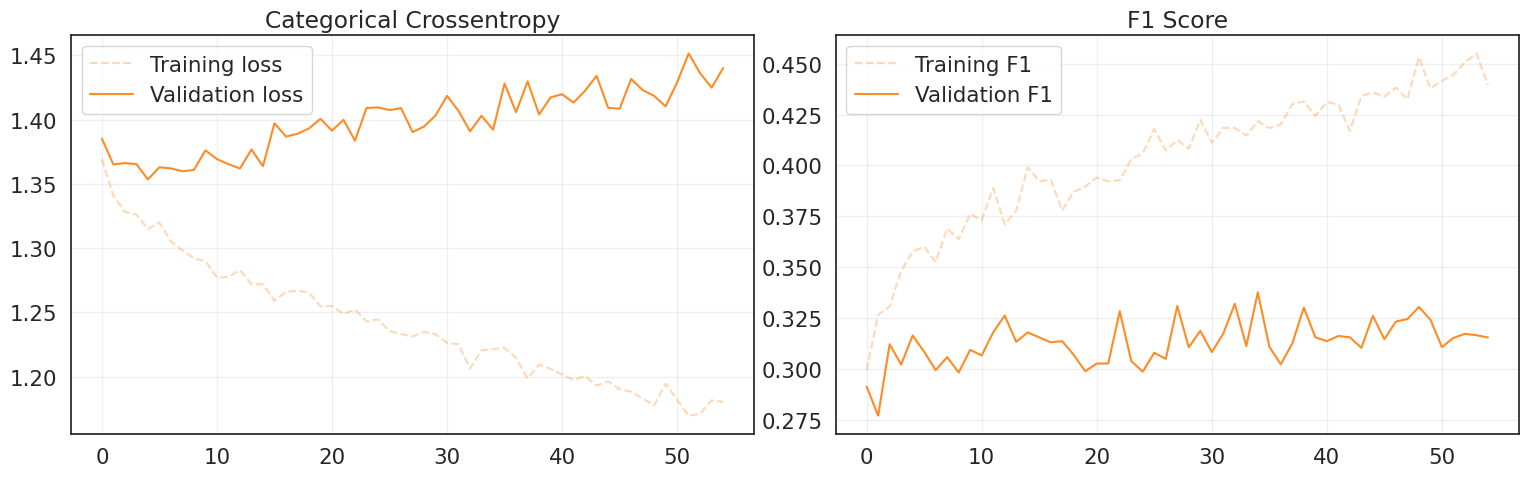

CPU times: user 19min 29s, sys: 4.85 s, total: 19min 34s
Wall time: 19min 44s


In [19]:
%%time
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=EXPERIMENT_NAME,
    patience=PATIENCE,
    scheduler=scheduler
)

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)

# Print model save location
model_path = os.path.join(current_dir, "models", EXPERIMENT_NAME + '_model.pt')
print(f"\n{'='*80}")
print(f"Training completed! Model saved to: {model_path}")
print(f"Best validation F1 score: {final_val_f1}%")
print(f"{'='*80}\n")

# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation F1 score on the second axis
ax2.plot(tl_history['train_f1'], label='Training F1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(tl_history['val_f1'], label='Validation F1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [20]:
# Collect predictions and ground truth labels using augmented test loader
test_preds, test_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in test_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = tl_model(xb)
        preds = F.softmax(logits, dim=1).cpu().numpy()

        # Store batch results
        test_preds.append(preds)
        test_targets.append(yb.numpy())

# Combine all batches into single arrays
test_probs = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

Accuracy over the test set: 0.3864
Precision over the test set: 0.3897
Recall over the test set: 0.3864
F1 score over the test set: 0.3802

Confusion Matrix:
               Luminal A      Luminal B      HER2(+)        Triple negative
--------------------------------------------------------------------------------
Luminal A                   16              3              5              2
Luminal B                    6             12             10              3
HER2(+)                      7              6              5              1
Triple negative              4              2              5              1

Rows: True labels, Columns: Predicted labels


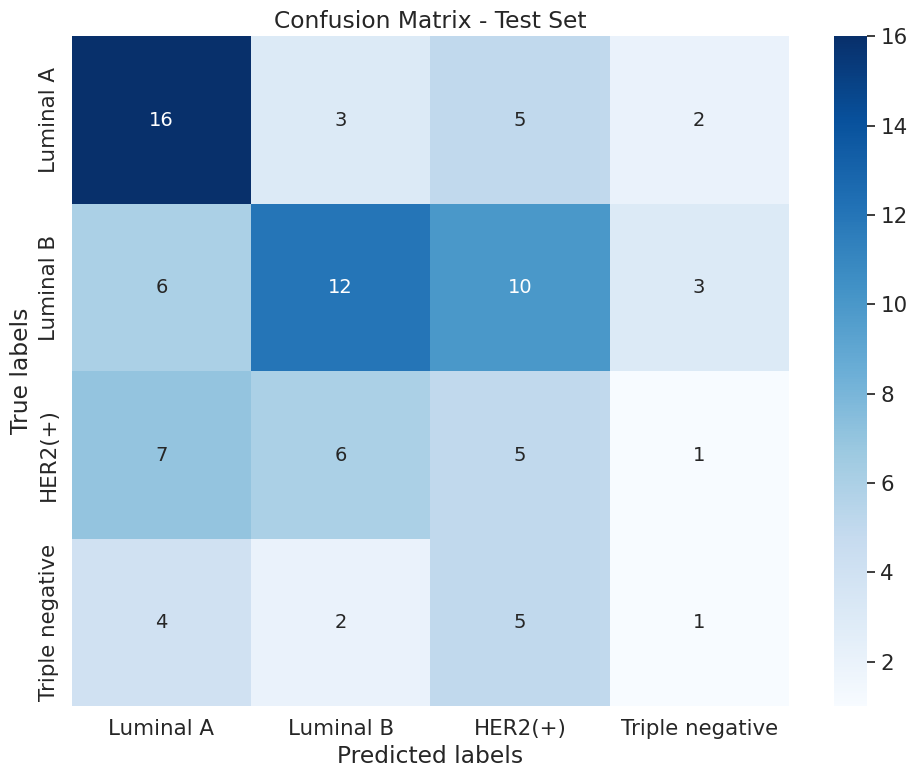

In [21]:
from collections import defaultdict

image_probs = defaultdict(list)
image_targets = {}

for i, (probs, target, img_i) in enumerate(zip(test_probs, test_targets, image_idx_test)):
    image_probs[img_i].append(probs)
    image_targets[img_i] = target  # Same for all patches of this image

# Aggregate: average probabilities, then argmax
final_preds = []
final_targets = []
for img_i in sorted(image_probs.keys()):
    avg_probs = np.mean(image_probs[img_i], axis=0)
    final_preds.append(avg_probs.argmax())
    final_targets.append(image_targets[img_i])

final_preds = np.array(final_preds)
final_targets = np.array(final_targets)

# Calculate overall test metrics
test_acc = accuracy_score(final_targets, final_preds)
test_prec = precision_score(final_targets, final_preds, average='weighted')
test_rec = recall_score(final_targets, final_preds, average='weighted')
test_f1 = f1_score(final_targets, final_preds, average='weighted')
print(f"Accuracy over the test set: {test_acc:.4f}")
print(f"Precision over the test set: {test_prec:.4f}")
print(f"Recall over the test set: {test_rec:.4f}")
print(f"F1 score over the test set: {test_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(final_targets, final_preds)

# Class names for the confusion matrix
class_names = ['Luminal A', 'Luminal B', 'HER2(+)', 'Triple negative']

# Print confusion matrix textually
print("\nConfusion Matrix:")
print("="*80)
print(f"{'':15s}", end='')
for name in class_names:
    print(f"{name:15s}", end='')
print()
print("-"*80)
for i, true_label in enumerate(class_names):
    print(f"{true_label:15s}", end='')
    for j in range(len(class_names)):
        print(f"{cm[i][j]:15d}", end='')
    print()
print("="*80)
print(f"\nRows: True labels, Columns: Predicted labels")

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=labels, fmt='',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

### Generate predictions
To generate predictions for submission, we load test patches, predict on each patch, then aggregate predictions per image by averaging probabilities.

In [22]:
# Generate predictions for the actual test set (no labels)

# Create inverse mapping from class index to label name
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Prepare test patches into flat arrays similar to training
X_test_list = []
image_idx_test_list = []  # Track which image each patch belongs to

for i, patches in enumerate(test_patches):
    for patch in patches:
        X_test_list.append(patch)
        image_idx_test_list.append(i)  # Track source image

X_test_final = np.array(X_test_list)  # Shape: (total_patches, H, W, 3)
image_idx_test_final = np.array(image_idx_test_list)  # Shape: (total_patches,)

print(f"Test patches: {len(X_test_final)} patches from {len(test_patches)} images")

# Create dummy labels (required by AugmentDataset but not used)
dummy_labels = np.zeros(len(X_test_final), dtype=np.int64)

# Prepare test dataset with ImageNet normalization (no augmentation)
final_test_ds = AugmentDataset(
    X_test_final,
    dummy_labels,
    augmentation=None,
    normalize="imagenet"  # Same normalization as training
)
final_test_loader = DataLoader(
    final_test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Generate predictions for all patches
test_patch_probs = []
with torch.no_grad():
    for xb, _ in final_test_loader:  # Ignore dummy labels
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = tl_model(xb)
        probs = F.softmax(logits, dim=1).cpu().numpy()

        # Store batch results
        test_patch_probs.append(probs)

# Combine all batches into single array
test_patch_probs = np.concatenate(test_patch_probs)

# Aggregate predictions per image (average probabilities across patches)
from collections import defaultdict

image_probs = defaultdict(list)

for i, (probs, img_i) in enumerate(zip(test_patch_probs, image_idx_test_final)):
    image_probs[img_i].append(probs)

# Average probabilities and get final predictions
final_test_preds = []
for img_i in sorted(image_probs.keys()):
    avg_probs = np.mean(image_probs[img_i], axis=0)
    final_test_preds.append(avg_probs.argmax())

final_test_preds = np.array(final_test_preds)

# Create submission dataframe using test image indices
submission_df = pd.DataFrame({
    'sample_index': [f'img_{test_imageIndeces[i]:04d}.png' for i in range(len(final_test_preds))],
    'label': [inverse_label_mapping[pred] for pred in final_test_preds]
})


# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print(f"Submission file created with {len(submission_df)} predictions")
print(f"\nPrediction distribution:")
print(submission_df['label'].value_counts())

Test patches: 5724 patches from 477 images
Submission file created with 477 predictions

Prediction distribution:
label
HER2(+)            143
Luminal B          139
Luminal A          139
Triple negative     56
Name: count, dtype: int64
